In [ ]:
#@title Importing All Libraries
import os
import gc
import torch
import torchaudio
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
#@title Mounting Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
#@title Listing All Libraries
lst = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

In [ ]:
#@title Function Defination to Plot Spectrogram
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
   waveform = waveform.numpy()
   num_channels, num_frames = waveform.shape
   figure, axes = plt.subplots(num_channels, 1)
   if num_channels == 1:
       axes = [axes]
   for c in range(num_channels):
       axes[c].specgram(waveform[c], Fs=sample_rate)
       if num_channels > 1:
           axes[c].set_ylabel(f"Channel {c+1}")
       if xlim:
           axes[c].set_xlim(xlim)
   plt.xticks([]), plt.yticks([])

In [ ]:
#@title Making Training and Testing Directories to Store Spectrogram
os.mkdir('/content/Train_image')
for i in range(0,10):
  os.mkdir('/content/Train_image/' + lst[i])

os.mkdir('/content/Test_image')
for i in range(0,10):
  os.mkdir('/content/Test_image/' + lst[i])

In [ ]:
#@title Plotting Training Spectrograms
for i in range(0,10):
  
  dir_path = '/content/Drive/MyDrive/GTZAN_audio/' + lst[i]
  lst1 = os.listdir(dir_path)
  os.chdir('/content/Train_image/' + lst[i])

  for j in range(0,90):
    path = dir_path + '/' + lst1[j]

    if path != '/content/Drive/MyDrive/GTZAN_audio/jazz/jazz.00054.wav':

      waveform , sample_rate = torchaudio.load(path)

      plot_specgram(waveform, sample_rate, lst1[j])
      plt.savefig(lst1[j] + '.png')
      plt.close()

    else:
      pass

gc.collect()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


0

In [ ]:
#@title Plotting Testing Spectrograms
for i in range(0,10):
  
  dir_path = '/content/Drive/MyDrive/GTZAN_audio/' + lst[i]
  lst1 = os.listdir(dir_path)
  os.chdir('/content/Test_image/' + lst[i])

  for j in range(90,100):
    path = dir_path + '/' + lst1[j]

    if path != '/content/Drive/MyDrive/GTZAN_audio/jazz/jazz.00054.wav':

      waveform , sample_rate = torchaudio.load(path)

      plot_specgram(waveform, sample_rate, lst1[j])
      plt.savefig(lst1[j] + '.png')
      plt.close()

    else:
      pass

gc.collect()

1464471

In [ ]:
#@title Loading Dataset to Normalise Dataset
transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.ImageFolder('/content/Train_image', transform = transform)
data = DataLoader(data_set, batch_size = 1000, shuffle = True)

In [ ]:
#@title Calculating Mean and Standard Deviation
mean = 0
std = 0
for k, (images, labels) in enumerate(data):
  mean += torch.mean(images)
  std += torch.std(images)

mean = mean/(k+1)
std = std/(k+1)

In [ ]:
#@title Deleting Previous Datasets
del data_set
del data

In [ ]:
#@title Loading Normalised Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std), transforms.Resize((144,144))])
data_set = torchvision.datasets.ImageFolder('/content/Train_image', transform = transform)
data = DataLoader(data_set, batch_size = 100, shuffle = True)

In [ ]:
#@title Selecting Device
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
#@title Checking Image Dimensions
img = mpimg.imread('/content/Train_image/blues/blues.00027.wav.png')
print(img.shape)

(288, 432, 4)


In [ ]:
#@title Defining Neural Network Class
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.L1 = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(15),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.1)
    )
    self.L2 = nn.Sequential(
        nn.Conv2d(15, 45, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(45),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.3)
    )
    self.L3 = nn.Sequential(
        nn.Conv2d(45, 75, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(75),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.1)
    )
    self.L4 = nn.Linear(18*18*75, 5000)
    self.L5 = nn.Linear(5000, 500)
    self.L6 = nn.Linear(500, 100)
    self.L7 = nn.Linear(100, 10)

  def forward(self, x):
    out = self.L1(x)
    out = self.L2(out)
    out = self.L3(out)
    out = out.reshape(out.size(0), -1)
    out = self.L4(out)
    out = F.relu(out)
    out = self.L5(out)
    out = F.relu(out)
    out = self.L6(out)
    out = F.relu(out)
    out = self.L7(out)
    out = F.log_softmax(out, dim=1)
    return out

In [ ]:
#@title Creating a Neural Network Object
NeuralNet = Net()
NeuralNet = NeuralNet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNet.parameters(), lr=5e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

In [ ]:
#@title Training Neural Network
loss_func = []
accuracy = []

for i in range(0,100):
  torch.cuda.empty_cache()
  gc.collect()
  for k, (images,labels) in enumerate(data):
    images = images.to(device)
    labels = labels.to(device)
    output = NeuralNet(images)
    loss = criterion(output, labels)
    loss_func.append(float(loss))
    total = labels.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == labels).sum().item()
    acc = correct*100/total
    accuracy.append(acc)
    if k%10 == 0:
      print(loss)
      print(acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(2.3002, device='cuda:0', grad_fn=<NllLossBackward0>)
14.0
tensor(2.3714, device='cuda:0', grad_fn=<NllLossBackward0>)
10.0
tensor(2.1847, device='cuda:0', grad_fn=<NllLossBackward0>)
17.0
tensor(2.0303, device='cuda:0', grad_fn=<NllLossBackward0>)
24.0
tensor(1.8242, device='cuda:0', grad_fn=<NllLossBackward0>)
32.0
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
39.0
tensor(1.5021, device='cuda:0', grad_fn=<NllLossBackward0>)
43.0
tensor(1.2718, device='cuda:0', grad_fn=<NllLossBackward0>)
57.0
tensor(1.3067, device='cuda:0', grad_fn=<NllLossBackward0>)
54.0
tensor(1.3621, device='cuda:0', grad_fn=<NllLossBackward0>)
51.0
tensor(1.2308, device='cuda:0', grad_fn=<NllLossBackward0>)
58.0
tensor(1.0806, device='cuda:0', grad_fn=<NllLossBackward0>)
59.0
tensor(1.2671, device='cuda:0', grad_fn=<NllLossBackward0>)
49.0
tensor(1.1590, device='cuda:0', grad_fn=<NllLossBackward0>)
59.0
tensor(0.8495, device='cuda:0', grad_fn=<NllLossBackward0>)
69.0
tensor(0.8720, device='cu

KeyboardInterrupt: ignored

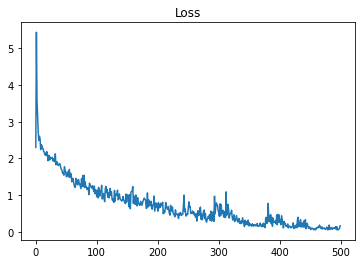

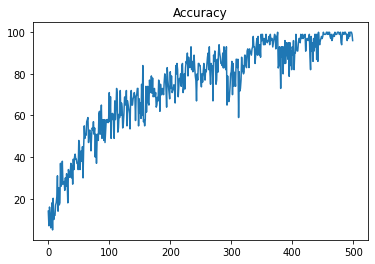

In [ ]:
#@title Plotting Loss And Accuracy of the Neural Network
plt.plot(loss_func)
plt.title("Loss")
plt.show()
plt.plot(accuracy)
plt.title("Accuracy")
plt.show()

In [ ]:
#@title Loading Test Dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((144,144))])
test_set = torchvision.datasets.ImageFolder('/content/Test_image', transform = trans)
test = DataLoader(test_set, batch_size = 100, shuffle = True)

In [ ]:
#@title Checking Test Accuracy
for k, (img,lab) in enumerate(test):
    img = img.to(device)
    lab = lab.to(device)
    output = NeuralNet(img)
    loss = criterion(output, lab)
    total = lab.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == lab).sum().item()
    acc = correct*100/total
    print(loss)
    print(acc)

tensor(1.2801, device='cuda:0', grad_fn=<NllLossBackward0>)
65.0
